<a href="https://colab.research.google.com/github/canamac/zeka-can/blob/main/10_coin_lorentz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-1-b618e9bb0ddd>:55: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_normalized = df_sharpe.applymap(lorentz_normalize)
<ipython-input-1-b618e9bb0ddd>:56: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_normalized_sortino = df_sortino.applymap(lorentz_normalize)
<ipython-input-1-b618e9bb0ddd>:57: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_normalized_calmar = df_calmar.applymap(lorentz_normalize)


Coins above BTC: []
Coins below BTC: []


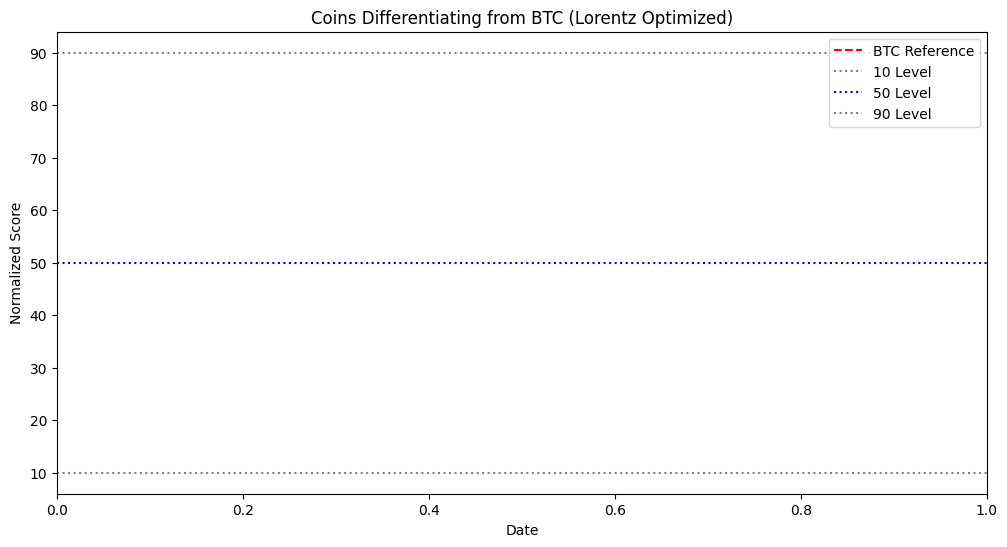

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests

# Kullanıcı tarafından belirlenen coin isimleri
coin_list = ["bitcoin", "ethereum", "cardano", "solana", "ripple", "polkadot", "dogecoin", "chainlink", "litecoin", "polygon"]

# CoinGecko API'den veri çekme
COINGECKO_URL = "https://api.coingecko.com/api/v3/coins/markets"
HEADERS = { 'User-Agent': 'Mozilla/5.0' }
PARAMS = {
    'vs_currency': 'usd',
    'ids': ','.join(coin_list),  # Belirtilen coinleri alıyoruz
    'order': 'market_cap_desc',
    'per_page': 10,
    'page': 1,
    'sparkline': False
}

response = requests.get(COINGECKO_URL, headers=HEADERS, params=PARAMS)
data = response.json()

# Coin fiyatlarını ve tarihleri alma
dates = pd.date_range(start="2024-01-01", periods=len(data), freq='D')
prices = {coin['id']: coin['current_price'] for coin in data}
df = pd.DataFrame(prices, index=dates)

# Risk-Free Rate
risk_free_rate = 0.001 / 60

# Getiri Hesaplamaları
df_returns = df.pct_change()

# Performans Oranları Hesaplamaları
df_stddev = df_returns.rolling(20).std()
df_avg_return = df_returns.rolling(20).mean()
df_sharpe = (df_avg_return - risk_free_rate) / df_stddev

df_negative_returns = df_returns.where(df_returns < 0)
df_downside_dev = df_negative_returns.rolling(20).std()
df_sortino = (df_avg_return - risk_free_rate) / df_downside_dev

df_max_drawdown = df.rolling(20).max() - df.rolling(20).min()
df_calmar = df_avg_return / df_max_drawdown

# Lorentz Normalizasyon Fonksiyonu
def lorentz_normalize(ratio):
    if ratio is None or ratio < -1 or ratio > 1:
        return np.nan
    transformed = np.sign(ratio) * np.log(1 + abs(ratio))
    return ((transformed + np.log(2)) / (2 * np.log(2))) * 100

# Lorentz Normalizasyonunu Uygula
df_normalized = df_sharpe.applymap(lorentz_normalize)
df_normalized_sortino = df_sortino.applymap(lorentz_normalize)
df_normalized_calmar = df_calmar.applymap(lorentz_normalize)

df_avg_normalized = (df_normalized + df_normalized_sortino + df_normalized_calmar) / 3

# Bitcoin'i referans alarak diğer coinleri karşılaştırma
btc_reference = df_avg_normalized["bitcoin"].mean()
coins_above_btc = [coin for coin in df_avg_normalized.columns if df_avg_normalized[coin].mean() > btc_reference]
coins_below_btc = [coin for coin in df_avg_normalized.columns if df_avg_normalized[coin].mean() < btc_reference]

print(f"Coins above BTC: {coins_above_btc}")
print(f"Coins below BTC: {coins_below_btc}")

# Bitcoin'den ayrışan coinleri gösterme
plt.figure(figsize=(12, 6))
for coin in coins_above_btc:
    plt.plot(df_avg_normalized.index, df_avg_normalized[coin], label=f'{coin} (Above BTC)', linestyle='solid')
for coin in coins_below_btc:
    plt.plot(df_avg_normalized.index, df_avg_normalized[coin], label=f'{coin} (Below BTC)', linestyle='dashed')

plt.axhline(btc_reference, color='red', linestyle='dashed', label='BTC Reference')
plt.axhline(10, color='gray', linestyle='dotted', label='10 Level')
plt.axhline(50, color='blue', linestyle='dotted', label='50 Level')
plt.axhline(90, color='gray', linestyle='dotted', label='90 Level')

plt.legend()
plt.title("Coins Differentiating from BTC (Lorentz Optimized)")
plt.xlabel("Date")
plt.ylabel("Normalized Score")
plt.show()
